----
# Skill Homework #6 - Fitting Data to a Model
----



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.odr as odr
#
# Now make some data
np.random.seed(20150108) # seed the random number generator so eveyone has the same data
time = np.linspace(0, 2, 101)
volts = 2.5 * np.sin(2 * np.pi * time - 1.0) + np.random.normal(0,0.1,len(time))

# Introduction
A very important data analysis skill is fitting a model to your data. Let's set up the situation with the data we simulated above. You have measured the output voltage from a system and it is delayed by some amount from your input signal which has the form $V(t) = 1.0 \sin(2 \pi t)$. You want to know the amplitude of the output and the time delay.

You almost **always** want to start your data analysis by plotting your data, so that is what you should do first in the cell below. plot the data as dots, and your input as a red line. Your plot should look like the figure below.

![First Plot](./Skill-06a.png)

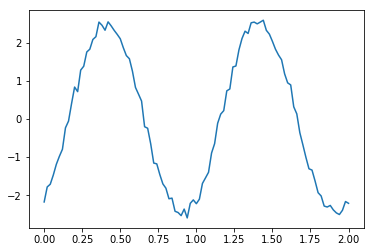

In [2]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time, volts)

# The Module `opt.odr`
The module we are going to use to fit data to a model is called `odr` which stands for *Orthogonal Distance Regression*. We are going to treat it as a black box, but what it does is minimize the average distance between each data point and the closest point on the model function. This module is in the `optimize` module which in turn is in the module `scipy`. The `optimize` module is imported as `opt` at the begining of this notebook. There are six steps to using `odr`.

## 1. Write Your model Function
In our case, we know the time dependence of the output goes as $\sin(2\pi t)$. What we don't know (so what we have to fit for) is the amplitude and the starting time. Let's call the amplitude `amp` and the start time `t0`, so the model function we are fitting is $V_{out} = amp * \sin(2 * \pi * (t - t_0))$. The module `odr` needs a function with two parameters. The first is an array of the parameters, in this case `[amp, t0]`. The second parameter is the data array.

Here is a skeleton of the function. In the cell below you have to modify the function to work and return an array of the model function value for each x-value.
```
def vModel(Params, time):
    amp = Params[0]
    t0 = Params[1]
    return # put your return function in here
```

In [6]:
def vModel(Params, time):
    amp = Params[0]
    t0 = Params[1]
    return amp * np.sin(time + t0)

## 2. Create Your Model and Data Wrappers
For `odr` your function has to *wrapped* in a `Model` instance. This done by the code
```
myModel = odr.Model(vModel)
```

Your data array must also be wrapped, this time in a `Data` instance. You must supply an uncertainty for both the x- and y-values. If the uncertainty is the same for all of the x-values, `sx` can be set to a single value; likewise for `sy`. If either of them has individual uncertainties, then the corresponding `sx` or `sy` can be assigned an array of the same length as the data arrays.
```
myData = odr.RealData(time, volts, sx=0.01, sy=0.1)
```

Cut and paste this code into the cell below and run the cell.

In [7]:
myModel = odr.Model(vModel)
myData = odr.RealData(time, volts, sx=0.01, sy=0.1)

## 3. Instantiate ODR with your data, model and initial parameter estimates

You need one other piece of information, you initial guesses for the parameters. You usually do not need to be too close, but in the ball park. In this case, you can look at the data and guess that `amp` should be about `2.5`. You can guess the start time by guessing when the data crosses the x-axis. Let's say `0.2`. You have to create an array with your initial guesses.
```
initParams = np.array([2.5, 0.2])
```

Next you have to create an instance of `odr` using a call like
```
myOdr = odr.ODR(myData, myModel, beta0=initParams)
```

In [8]:
initParams = np.array([2.5, 0.2])
myOdr = odr.ODR(myData, myModel, beta0=initParams)

## 4. Run the Data Fit
This is easy. Just run the code
```
myOutput = myOdr.run()
```

## 5. Look at the Results
The `output` instance returned has all of the results as attributes, and the `pprint` (Pretty PRINT) method summarizes them in a nice format.

Run the line `myOutput.pprint()` in the cell below to see the results.

### Interpreting the Results
The array `myOutput.beta` are the best fit values of the parameters. I like to create new variable with these these values for use later. The line 
```
(ampFit, t0Fit) = myOutput.beta
```
creates two new variable in one compact line of code.

A second very important result is the **uncertainty** in your fit parameters. These are returned in the attribute `myOutput.sd_beta`. Like the previous example, you can capture these by the code
```
(ampSD, t0SD) = myOutput.
```
I like to clearly print these out for the use. I will capture the output in a string and print the string because I am going to use the string later in a plot. Copy and paste this code:
```
resultStr = \
r"""The amp is %.3f $\pm$ %.3f
The t0 is %.3f $\pm$ %.3f""" % \
print resultStr
```

The *covariance* is how much the value of `amp` is correlated with the value of `t0`.

The *residual variance* is the average distance the data points are from the model function.

A final issue you should always check is the reason the fit stopped. If it isn't because the fit *converged*, then there may be a problem with the fit. If there is a problem, you need to check your data, your model function or look for another reason the fit did not converge.

# Plotting Your Results
By now you should be able to plot the data and the model on the same figure. Here are some hints:
* The output array `myOutput.beta` has the best values for the parameters, so you can use that to calculate your model. I used the call `vModel(myOutput.beta,time)` right in my call to `ax.plot`.
* I also used the method `ax.text` to write the best values right on my plot. The actual call is `ax.text(0.1,2.8,resultStr)`.

This is how my final plot looked:
![First Plot](./Skill-06b.png)

Make your final plot in the cell below.

## Fixing Some Parameters
Sometimes when you fit data, you want to fix some of the parameters in your function. `odr` allows you to do that easily with the run paramter `ifixb`. For example in this case is you know your output amplitude is 2.5, you can fix that parameter and let `odr` find the best value for `t0`. All you have to do is add a parameter `ifixb=[0,1]` to the the method call `odr.ODR`. 

In the cell below do the fit with `amp` fixed at the value `2.5`. Make a plot of the data and model using your result.

In [ ]:
myOdr = odr.ODR(myData, myModel, initParams, ifixb=(0,1))
myOutput = myOdr.run()
myOutput.pprint()

# Using Two X-Axes

Some times you only have a few data points you are fitting, but you want to draw a smooth model curve with you data. In the cell below I've created an example and fit a model to the data.

In [ ]:
np.random.seed(4321)
tData2 = np.array([0.0,.15,.3,.6,.8,1.2,1.4,1.7,2])
vData2 = 2.1 * np.sin(2 * np.pi * tData2 - 1.2) + np.random.normal(0,0.1,len(tData2))
myData2 = odr.RealData(tData2, vData2, sx=0.02, sy=0.1)
initParams2 = np.array([2.5,.1])
myOdr2 = odr.ODR(myData2, myModel, initParams2)
myOutput2 = myOdr2.run()
myOutput2.pprint()
(ampFit2, t0Fit2) = myOutput2.beta
(ampSD2, t0SD2) = myOutput2.sd_beta
resultStr2 = \
r"""The amp is %.3f $\pm$ %.3f
The t0 is %.3f $\pm$ %.3f""" % \
  (ampFit2, ampSD2, t0Fit2, t0SD2)
print
print resultStr2

Plot your data in the cell below.

That doesn't look very good, does it? The solution is to define a new time axis with a lot more data points. Create a time axis using `tPlot -= np.linspace(0,2, 1001)`, and plot your model calculated at those values.

Your plot should look similar this: 
![First Plot](./Skill-06c.png)

# Other Topics
There are many other data fitting topics I won't cover. You can Google them to find out. Here are some:
* **Error Bars** Sometimes you want to plot error bars on your data
* Correlated fit parameters

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()